# Pre-Preparation

In [ ]:
# Install Roboflow untuk Download dataset
! pip install Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Dataset Preparation

In [ ]:
# Download dataset dari Project di Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="NqMSpG0TwEe3h0vlKWD8")
project = rf.workspace("persotrak").project("cctv-naxyo-qlj4m")
dataset = project.version(1).download("COCO")

loading Roboflow workspace...
loading Roboflow project...

Version export complete for COCO format



Extracting Dataset Version Zip to cctv-1 in COCO:: 100%|██████████| 3741/3741 [00:00<00:00, 5435.27it/s]


In [ ]:
import json

annotation_path = '/content/cctv-1/train/_annotations.coco.json'
with open(annotation_path, 'r') as f:
    coco_data = json.load(f)

# Cek Jumlah Class dan ID
print("Categories in the dataset:")
for category in coco_data.get('categories', []):
    print(f"ID: {category['id']}, Name: {category['name']}")

Categories in the dataset:
ID: 0, Name: person
ID: 1, Name: person


In [ ]:
import json

annotation_path = '/content/cctv-1/train/_annotations.coco.json'
with open(annotation_path, 'r') as f:
    coco_data = json.load(f)

# Cek Jumlah Class dan ID
print("Categories in the dataset:")
for category in coco_data.get('categories', []):
    if category['id'] == 0:
        category['name'] = 'background'
    print(f"ID: {category['id']}, Name: {category['name']}")

Categories in the dataset:
ID: 0, Name: background
ID: 1, Name: person


In [ ]:
# Import Library Pendukung
import os
import random
import pandas as pd
from PIL import Image
import cv2
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import json
from torchvision.io import read_image, ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class CCTVImgDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load semua file images dan pastikan filenya teratur
        self.imgs = list(sorted(os.listdir(os.path.join(root, "train"))))
        self.annotations_path = os.path.join(root, "train", "_annotations.coco.json")

        with open(self.annotations_path, 'r') as f:
            self.coco_data = json.load(f)

        # Buat Mapping dari Image ID untuk Annotations
        self.img_id_to_annotations = {}
        for anno in self.coco_data['annotations']:
            img_id = anno['image_id']
            if img_id not in self.img_id_to_annotations:
                self.img_id_to_annotations[img_id] = []
            self.img_id_to_annotations[img_id].append(anno)

        # Buat mapping dari image name untuk image ID
        self.img_filename_to_id = {}
        for img_info in self.coco_data['images']:
            self.img_filename_to_id[img_info['file_name']] = img_info['id']

        # Filter image yang formatnya tidak support / tidak punya anotasi
        valid_imgs = []
        for img_filename in self.imgs:
            img_id = self.img_filename_to_id.get(img_filename)
            if img_id is not None and img_id in self.img_id_to_annotations:
                img_path = os.path.join(self.root, "train", img_filename)
                try:
                    # Mencoba membaca file image untuk memastikan formatnya support atau tidak
                    read_image(img_path)
                    valid_imgs.append(img_filename)
                except RuntimeError:
                    print(f"Skipping unsupported image format: {img_filename}")
            else:
                print(f"Skipping image with no annotations or missing info: {img_filename}")

        self.imgs = valid_imgs


    def __getitem__(self, idx):
        # load images dan mask-nya
        img_path = os.path.join(self.root, "train", self.imgs[idx])
        img = read_image(img_path)

        # Temukan image ID untuk gambar yang diload
        img_id = self.img_filename_to_id[self.imgs[idx]]

        # Dapatkan annotations dari image ID
        annotations = self.img_id_to_annotations.get(img_id, [])

        # Dapatkan bounding box dari setiap masking
        boxes = []
        labels = []
        masks = []
        image_id = img_id # Gunakanimage_id yang sebenarnya dari coco_data sebagai integer biasa.
        area = []
        iscrowd = []

        for anno in annotations:
            x, y, w, h = anno['bbox']
            # Memastikan bounding box valid dan sesuai dengan dimensi gambar
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            # Clamp coordinates harus berada dalam bounding image
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(img.shape[2], x_max) # img.shape is (C, H, W)
            y_max = min(img.shape[1], y_max)

            # Only add box if it's valid (min <= max)
            if x_max > x_min and y_max > y_min:
                boxes.append([x_min, y_min, x_max, y_max])
                # Map category_id 0 and 1 to label 1 (Person)
                if anno['category_id'] in [0, 1]:
                    labels.append(1) # Map Person to label 1
                else:
                     # Tangani kategori lain jika perlu, seperti petakan ke label tertentu / skip
                     print(f"Warning: Skipping annotation with unexpected or background category_id: {anno['category_id']}")
                     continue # Skip annotation

                # Untuk dataset COCO, mask seringkali tidak disediakan secara langsung dalam anotasi.
                # Jika Anda memiliki masking segmentasi, Anda akan memprosesnya di sini.
                # Untuk saat ini, kita akan membuat masker dummy atau menghandlenya berdasarkan data yang ada
                # Jika data COCO kita mencakup segmentasi, kita perlu menyesuaikannya.
                # Untuk tugas yang hanya menggunakan bounding box, Anda mungkin tidak memerlukan mask
                masks.append([[0]]) # Placeholder for mask
                area.append(anno['area'])
                iscrowd.append(anno['iscrowd'])
            else:
                print(f"Warning: Skipping invalid bounding box: {[x, y, w, h]} for image {self.imgs[idx]}")


        # Jika tidak ditemukan anotasi yang valid pada sebuah gambar, kembalikan tensor.
        if len(boxes) == 0:
            boxes = torch.empty((0, 4), dtype=torch.float32)
            labels = torch.empty((0,), dtype=torch.int64)
            masks = torch.empty((0, 1, img.shape[-2], img.shape[-1]), dtype=torch.uint8)
            area = torch.empty((0,), dtype=torch.float32)
            iscrowd = torch.empty((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8) # Adjust dtype if needed
            area = torch.as_tensor(area, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([image_id]) # image_id harus tensor
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Periksa nilai invalid pada target
        if not torch.isfinite(target['boxes']).all():
            print(f"Error: Found non-finite values in boxes for image {self.imgs[idx]}")
            print(target['boxes'])
            raise ValueError("Non-finite values in bounding boxes")


        if target['labels'].numel() > 0 and (target['labels'] <= 0).any() or (target['labels'] > 2).any():
             print(f"Error: Found invalid labels for image {self.imgs[idx]}")
             print(target['labels'])
             raise ValueError("Invalid labels found")


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Inisialisasi dataset
dataset = CCTVImgDataset('/content/cctv-1', transforms=None)

Skipping image with no annotations or missing info: 00032_jpg.rf.8a34117758ebba9616b859bec13d0627.jpg
Skipping image with no annotations or missing info: 00041_jpg.rf.a1f9401239af27f0ab2cdd501d675110.jpg
Skipping image with no annotations or missing info: 00075_jpg.rf.9a8b9e45f0b5b8892213ba9a09a92322.jpg
Skipping image with no annotations or missing info: 00179_jpg.rf.c423499ab97838f30753bf2aa0239a5e.jpg
Skipping image with no annotations or missing info: 00185_jpg.rf.e341a1400e16c6c3fbe873b3153aae2e.jpg
Skipping image with no annotations or missing info: 00190_jpg.rf.da899bb8ffb4cfcd0855bf937362d896.jpg
Skipping image with no annotations or missing info: 00198_jpg.rf.d015564a273b775aa1b85c2e8d449578.jpg
Skipping image with no annotations or missing info: 01077_jpg.rf.ca4b24bd3c1d1e95d2fb3063cf5c2326.jpg
Skipping image with no annotations or missing info: 01123_jpg.rf.fa425c2d482fcea6a478ff119394390c.jpg
Skipping image with no annotations or missing info: 01133_jpg.rf.d6993205e3aade7e6

In [ ]:
index=0
print(dataset[index])
dataset[index][0]

(tensor([[[200, 200, 201,  ..., 173, 172, 171],
         [201, 201, 202,  ..., 173, 172, 171],
         [202, 202, 202,  ..., 173, 172, 171],
         ...,
         [153, 154, 144,  ...,  63,  57,  45],
         [150, 153, 143,  ...,  73,  72,  63],
         [145, 149, 141,  ...,  77,  81,  74]],

        [[200, 200, 201,  ..., 191, 190, 189],
         [201, 201, 202,  ..., 191, 190, 189],
         [202, 202, 202,  ..., 191, 190, 189],
         ...,
         [137, 138, 128,  ...,  58,  52,  40],
         [132, 135, 125,  ...,  68,  67,  58],
         [127, 131, 123,  ...,  72,  76,  69]],

        [[192, 192, 193,  ..., 215, 214, 213],
         [193, 193, 194,  ..., 215, 214, 213],
         [194, 194, 194,  ..., 215, 214, 213],
         ...,
         [103, 104,  94,  ...,  54,  48,  36],
         [ 96,  99,  89,  ...,  64,  63,  54],
         [ 91,  95,  87,  ...,  68,  72,  65]]], dtype=torch.uint8), {'boxes': tensor([[463.0000, 156.0000, 478.5000, 204.0000],
        [482.0000, 173.00

tensor([[[200, 200, 201,  ..., 173, 172, 171],
         [201, 201, 202,  ..., 173, 172, 171],
         [202, 202, 202,  ..., 173, 172, 171],
         ...,
         [153, 154, 144,  ...,  63,  57,  45],
         [150, 153, 143,  ...,  73,  72,  63],
         [145, 149, 141,  ...,  77,  81,  74]],

        [[200, 200, 201,  ..., 191, 190, 189],
         [201, 201, 202,  ..., 191, 190, 189],
         [202, 202, 202,  ..., 191, 190, 189],
         ...,
         [137, 138, 128,  ...,  58,  52,  40],
         [132, 135, 125,  ...,  68,  67,  58],
         [127, 131, 123,  ...,  72,  76,  69]],

        [[192, 192, 193,  ..., 215, 214, 213],
         [193, 193, 194,  ..., 215, 214, 213],
         [194, 194, 194,  ..., 215, 214, 213],
         ...,
         [103, 104,  94,  ...,  54,  48,  36],
         [ 96,  99,  89,  ...,  64,  63,  54],
         [ 91,  95,  87,  ...,  68,  72,  65]]], dtype=torch.uint8)

### Exploration Data Analyst

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch # Import torch

# Function untuk memvisualisasikan image dengan bounding box dan label
def visualize_sample(image, target, class_names=None):
    # Konvert image tensor ke numpy array dan ubah channel sesuai dengan matplotlib
    # image sudah mempunyai tensor dengan (C, H, W) dari dataset
    if isinstance(image, torch.Tensor):
        # Move tensor to CPU before converting to numpy
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        # jika bukan dalam tensor, asumsikan sebagai numpy array dan tangani sesuai formatnya
        image_np = image


    fig, ax = plt.subplots(1)
    # Tampilkan image menggunakan numpy array
    ax.imshow(image_np.astype(np.uint8))


    for i in range(len(target['boxes'])):
        # Move tensors to CPU before converting to numpy
        box = target['boxes'][i].cpu().numpy()
        label = target['labels'][i].item()
        score = target.get('scores', None) # Get score if available


        # Create a Rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Tambahkan label dan score
        display_text = ""
        # Ensure label is within the bounds of class_names if class_names is a list
        if class_names and label < len(class_names):
            display_text += class_names[label]
        # If class_names is a dictionary, use .get()
        elif isinstance(class_names, dict) and label in class_names:
             display_text += class_names[label]
        else:
             display_text += f'Class: {label}'

        if score is not None:
             # Move score tensor to CPU before converting to item/numpy
             display_text += f': {score[i].cpu().item() * 100:.2f}%' # Add score as percentage


        plt.text(box[0], box[1] - 5, display_text, color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


    plt.show()

# dpatkan class names dari dataset coco_data
# Asumsikan category_id 0 sesuai dengan kateogri pertama coco_data ['categories'] dan begitu seterusnya.
# Hal ini mungkin memerlukan penyesuaian tergantung pada bagaimana category_id dipetakan dalam anotasi.
# Assuming the dataset object is available in the environment
if 'dataset' in locals() and hasattr(dataset, 'coco_data'):
    class_names = [cat['name'] for cat in dataset.coco_data.get('categories', [])]
elif 'dataset' in locals() and isinstance(dataset, torch.utils.data.Subset) and hasattr(dataset.dataset, 'coco_data'):
    class_names = [cat['name'] for cat in dataset.dataset.coco_data.get('categories', [])]
else:
    print("Warning: Could not automatically determine class names from dataset. Using default labels.")
    class_names = None # Set to None if class names cannot be determined


# Tampilkan beberapa contoh prediksi sebelum training (menggunakan pre trained)
# Commenting out this section as it was for displaying pre-trained results and
# the subsequent cells handle model training and evaluation.
# num_samples_to_visualize = 3
# for i in range(num_samples_to_visualize):
#       image, target = dataset[i]
# visualize_sample(image, target, class_names)

# Model Preparation

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load model yang sudah dilatih menggunakan weight dari COCO_v1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # ganti head pada pretrained model
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = 2 # 2 object classes ('Person') + 1 background

model = get_model_instance_segmentation(num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 186MB/s]


In [ ]:
from torchvision.transforms import v2 as T
import torch

def get_transform(train):
    transforms = []
    # Konversikan image, baik berupa PIL maupun numpy array menjadi tensor pytorch dan mengubah tipe data menjadi float32
    transforms.append(T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]))

    if train:
        # Data augmentation untuk training
        transforms.append(T.RandomHorizontalFlip(0.5))

    # Normalisasi sesuai dengan ImageNet
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))


    return T.Compose(transforms)

In [ ]:
# Copy Repo faster RCNN
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py

--2025-11-03 07:37:51--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23628 (23K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]  23.07K  --.-KB/s    in 0s      

2025-11-03 07:37:52 (150 MB/s) - ‘transforms.py’ saved [23628/23628]

--2025-11-03 07:37:52--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) 

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.3 MB/s eta 0:00:00


# **Training Session**

In [ ]:
import torch

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Apply transforms when creating the dataset subsets
dataset_train = torch.utils.data.Subset(CCTVImgDataset('/content/cctv-1', get_transform(train=True)), indices[:-50])
dataset_test = torch.utils.data.Subset(CCTVImgDataset('/content/cctv-1', get_transform(train=False)), indices[-50:])


# define training and validation data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

Skipping image with no annotations or missing info: 00032_jpg.rf.8a34117758ebba9616b859bec13d0627.jpg
Skipping image with no annotations or missing info: 00041_jpg.rf.a1f9401239af27f0ab2cdd501d675110.jpg
Skipping image with no annotations or missing info: 00075_jpg.rf.9a8b9e45f0b5b8892213ba9a09a92322.jpg
Skipping image with no annotations or missing info: 00179_jpg.rf.c423499ab97838f30753bf2aa0239a5e.jpg
Skipping image with no annotations or missing info: 00185_jpg.rf.e341a1400e16c6c3fbe873b3153aae2e.jpg
Skipping image with no annotations or missing info: 00190_jpg.rf.da899bb8ffb4cfcd0855bf937362d896.jpg
Skipping image with no annotations or missing info: 00198_jpg.rf.d015564a273b775aa1b85c2e8d449578.jpg
Skipping image with no annotations or missing info: 01077_jpg.rf.ca4b24bd3c1d1e95d2fb3063cf5c2326.jpg
Skipping image with no annotations or missing info: 01123_jpg.rf.fa425c2d482fcea6a478ff119394390c.jpg
Skipping image with no annotations or missing info: 01133_jpg.rf.d6993205e3aade7e6

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# Define hyperparameters
learning_rate = 0.001
momentum = 0.9

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate,
                            momentum=momentum, weight_decay=0.0005)

Epoch 1/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 1 | Training Loss: 0.3316


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 1 Results:
   mAP@50: 0.8558
   mAP@50-95: 0.4952
   Average Inference Time (sec/img): 0.0244
⚠️ Warning: Inconsistent label lengths (true=174, pred=1856). Truncating to 174 samples for confusion matrix.


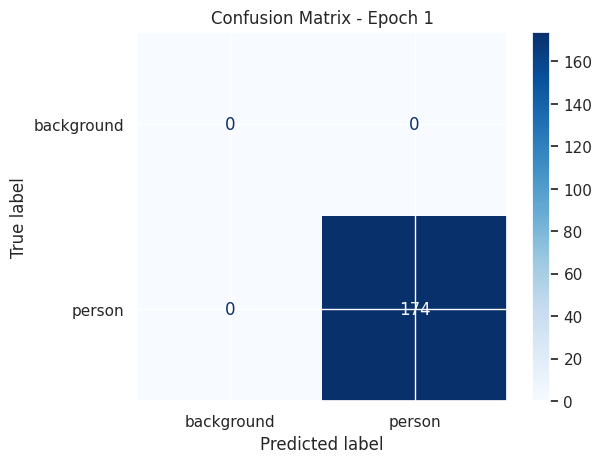

   Overall Precision: 1.0000
   Overall Recall: 1.0000
✅ Model improved, saved checkpoint.


Epoch 2/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 2 | Training Loss: 0.3198


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 2 Results:
   mAP@50: 0.8468
   mAP@50-95: 0.5021
   Average Inference Time (sec/img): 0.0244
⚠️ Warning: Inconsistent label lengths (true=174, pred=1254). Truncating to 174 samples for confusion matrix.


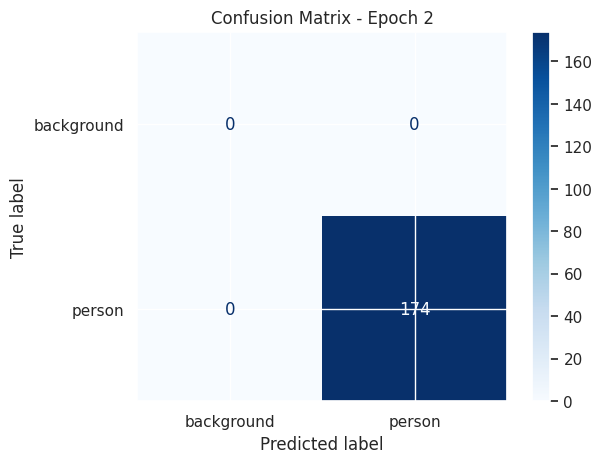

   Overall Precision: 1.0000
   Overall Recall: 1.0000
✅ Model improved, saved checkpoint.


Epoch 3/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 3 | Training Loss: 0.3087


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 3 Results:
   mAP@50: 0.8777
   mAP@50-95: 0.5002
   Average Inference Time (sec/img): 0.0243
⚠️ Warning: Inconsistent label lengths (true=174, pred=1487). Truncating to 174 samples for confusion matrix.


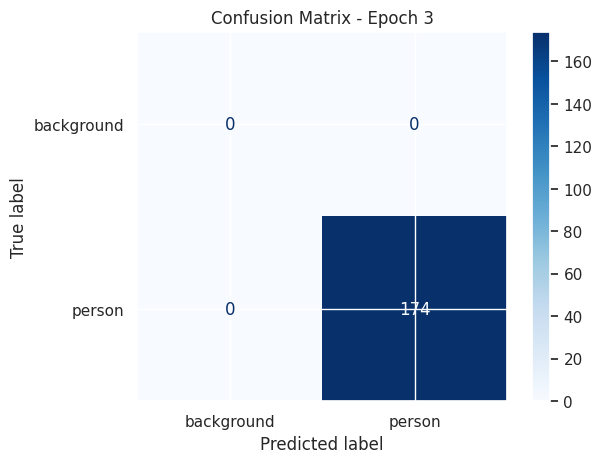

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 1/5


Epoch 4/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 4 | Training Loss: 0.3042


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 4 Results:
   mAP@50: 0.8600
   mAP@50-95: 0.4941
   Average Inference Time (sec/img): 0.0247
⚠️ Warning: Inconsistent label lengths (true=174, pred=797). Truncating to 174 samples for confusion matrix.


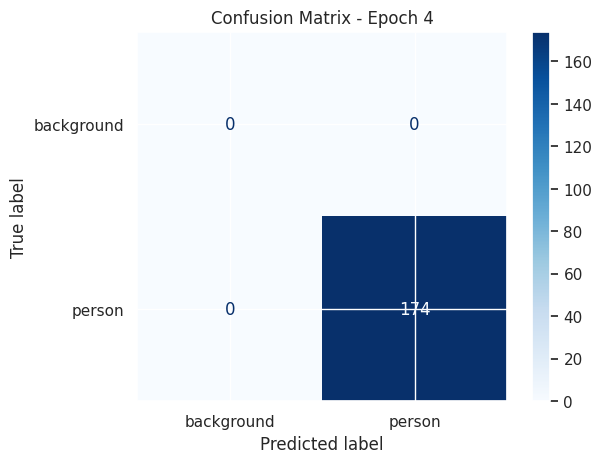

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 2/5


Epoch 5/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 5 | Training Loss: 0.2976


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 5 Results:
   mAP@50: 0.8853
   mAP@50-95: 0.5146
   Average Inference Time (sec/img): 0.0241
⚠️ Warning: Inconsistent label lengths (true=174, pred=880). Truncating to 174 samples for confusion matrix.


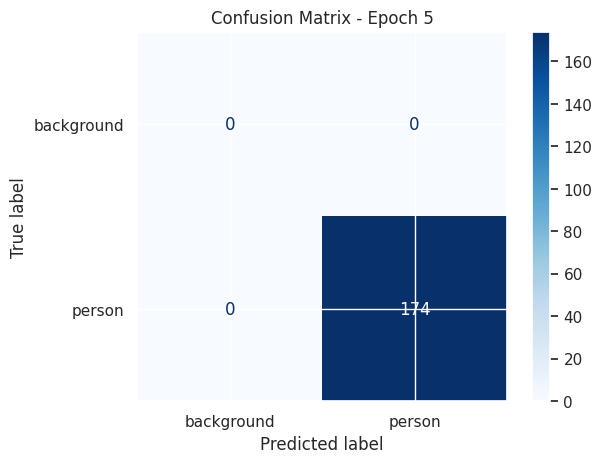

   Overall Precision: 1.0000
   Overall Recall: 1.0000
✅ Model improved, saved checkpoint.


Epoch 6/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 6 | Training Loss: 0.2890


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 6 Results:
   mAP@50: 0.8710
   mAP@50-95: 0.4920
   Average Inference Time (sec/img): 0.0241
⚠️ Warning: Inconsistent label lengths (true=174, pred=1005). Truncating to 174 samples for confusion matrix.


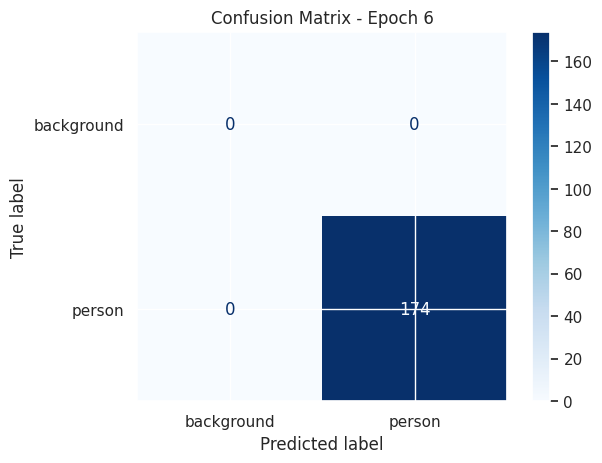

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 1/5


Epoch 7/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 7 | Training Loss: 0.2853


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 7 Results:
   mAP@50: 0.8508
   mAP@50-95: 0.4883
   Average Inference Time (sec/img): 0.0256
⚠️ Warning: Inconsistent label lengths (true=174, pred=767). Truncating to 174 samples for confusion matrix.


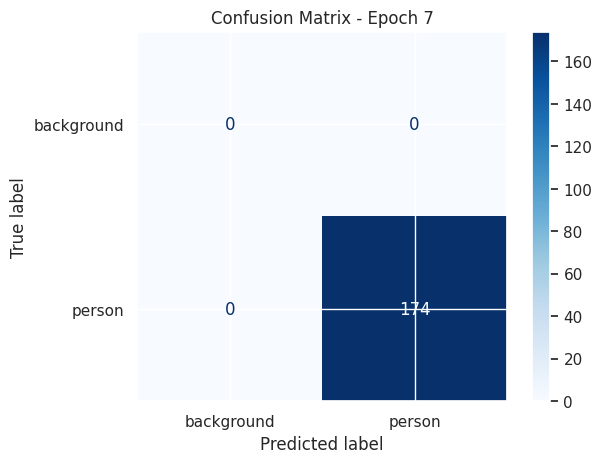

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 2/5


Epoch 8/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 8 | Training Loss: 0.2819


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 8 Results:
   mAP@50: 0.8322
   mAP@50-95: 0.4523
   Average Inference Time (sec/img): 0.0239
⚠️ Warning: Inconsistent label lengths (true=174, pred=828). Truncating to 174 samples for confusion matrix.


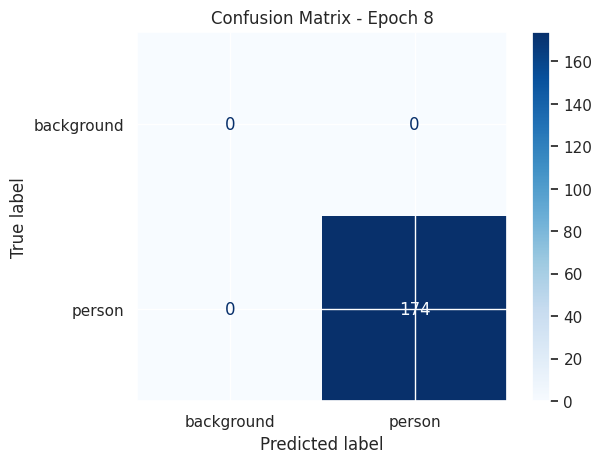

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 3/5


Epoch 9/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 9 | Training Loss: 0.2731


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 9 Results:
   mAP@50: 0.8734
   mAP@50-95: 0.4755
   Average Inference Time (sec/img): 0.0245
⚠️ Warning: Inconsistent label lengths (true=174, pred=907). Truncating to 174 samples for confusion matrix.


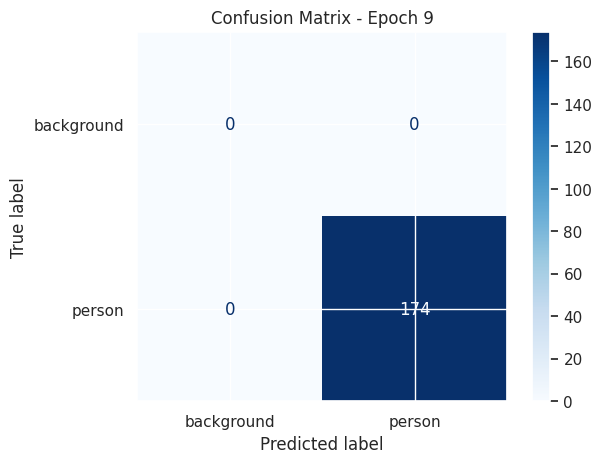

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 4/5


Epoch 10/10 (Training):   0%|          | 0/1834 [00:00<?, ?it/s]

Epoch 10 | Training Loss: 0.2635


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

📊 Epoch 10 Results:
   mAP@50: 0.8745
   mAP@50-95: 0.4948
   Average Inference Time (sec/img): 0.0252
⚠️ Warning: Inconsistent label lengths (true=174, pred=699). Truncating to 174 samples for confusion matrix.


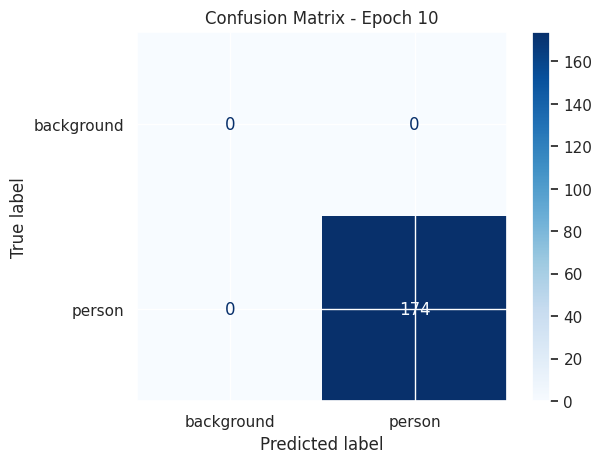

   Overall Precision: 1.0000
   Overall Recall: 1.0000
⚠️ No improvement. Early Stop Counter: 5/5
⏹ Early stopping triggered.
Training & Evaluation selesai!


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab compatibility
import torch
import time # Import time to calculate inference time

# --------------------------
# 1️⃣ Hyperparameter
# --------------------------
learning_rate = 0.001
momentum = 0.9
num_epochs = 10
patience = 5  # Early stopping patience

# Assuming dataset and dataset_test are already defined from previous cells
# dataset = CCTVImgDataset('/content/cctv-1', get_transform(train=True))
# dataset_test = CCTVImgDataset('/content/cctv-1', get_transform(train=False))

# Assuming model is already defined and moved to device
# model = get_model_instance_segmentation(num_classes)
# model.to(device)

# Assuming optimizer is already defined
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

best_map5095 = 0.0
patience_counter = 0

# --------------------------
# 2️⃣ Inisialisasi Metrik
# --------------------------
# Using torchmetrics for mAP, Precision, and Recall
metric_collection = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")

precision_list, recall_list, map50_list, map5095_list, loss_list, inference_time_list = [], [], [], [], [], []
all_true_labels_per_epoch = []
all_pred_labels_per_epoch = []


# --------------------------
# 3️⃣ Training Loop
# --------------------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", leave=False): # Use data_loader
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets if isinstance(t, dict)]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    avg_loss = total_loss / len(data_loader) # Divide by number of batches
    loss_list.append(avg_loss)
    print(f"Epoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    # --------------------------
    # 4️⃣ Evaluasi Model
    # --------------------------
    model.eval()
    metric_collection.reset()
    epoch_true_labels = []
    epoch_pred_labels = []
    epoch_inference_times = []


    with torch.no_grad():
        for images, targets in tqdm(data_loader_test, desc="Evaluating", leave=False): # Use data_loader_test
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets if isinstance(t, dict)]

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()
            epoch_inference_times.append((end_time - start_time) / len(images)) # Average time per image


            # Update metrik mAP
            # Ensure outputs and targets are on CPU for torchmetrics
            outputs_cpu = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
            targets_cpu = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
            metric_collection.update(outputs_cpu, targets_cpu)

            # Collect labels for confusion matrix and overall precision/recall
            for out, tgt in zip(outputs, targets):
                 # Filter predictions by confidence threshold if needed (e.g., 0.5)
                 # For confusion matrix, let's consider all predictions for now
                 pred_labels = out['labels'].cpu().numpy()
                 true_labels = tgt['labels'].cpu().numpy()

                 epoch_pred_labels.extend(pred_labels)
                 epoch_true_labels.extend(true_labels)


    # Compute and store metrics
    metrics = metric_collection.compute()
    map50 = metrics.get('map_50', torch.tensor(0.0)).item()
    map5095 = metrics.get('map', torch.tensor(0.0)).item()

    map50_list.append(map50)
    map5095_list.append(map5095)

    # Store collected labels for confusion matrix and overall precision/recall calculation later
    all_true_labels_per_epoch.append(epoch_true_labels)
    all_pred_labels_per_epoch.append(epoch_pred_labels)
    inference_time_list.append(np.mean(epoch_inference_times) if epoch_inference_times else 0) # Store average inference time


    print(f"📊 Epoch {epoch+1} Results:")
    print(f"   mAP@50: {map50:.4f}")
    print(f"   mAP@50-95: {map5095:.4f}")
    print(f"   Average Inference Time (sec/img): {inference_time_list[-1]:.4f}")


   # --------------------------
    # 5️⃣ Confusion Matrix & Overall Precision/Recall
    # --------------------------
    if epoch_true_labels and epoch_pred_labels:
      min_len = min(len(epoch_true_labels), len(epoch_pred_labels))
      if len(epoch_true_labels) != len(epoch_pred_labels):
          print(f"⚠️ Warning: Inconsistent label lengths (true={len(epoch_true_labels)}, pred={len(epoch_pred_labels)}). "
                f"Truncating to {min_len} samples for confusion matrix.")

      y_true = epoch_true_labels[:min_len]
      y_pred = epoch_pred_labels[:min_len]

      # 💡 Pastikan confusion matrix selalu punya 2 kelas: 0 (background) & 1 (person)
      label_names = ["background", "person"]
      cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
      disp.plot(cmap='Blues', values_format='d')
      plt.title(f"Confusion Matrix - Epoch {epoch+1}")
      plt.show()

      # Hitung precision & recall keseluruhan
      # Need to compute TP, FP, FN for class 'person' (label 1)
      # Assuming your confusion matrix is [[TN, FP], [FN, TP]] for labels [0, 1]
      TN, FP, FN, TP = cm.ravel() if cm.size == 4 else (0, 0, 0, 0) # Handle case where one class is missing


      precision = TP / (TP + FP) if (TP + FP) > 0 else 0
      recall = TP / (TP + FN) if (TP + FN) > 0 else 0

      precision_list.append(precision)
      recall_list.append(recall)

      print(f"   Overall Precision: {precision:.4f}")
      print(f"   Overall Recall: {recall:.4f}")
    else:
        print(f"Skipping Confusion Matrix (empty labels or preds).")
        precision_list.append(0.0)
        recall_list.append(0.0)


    # --------------------------
    # 6️⃣ Early Stopping
    # --------------------------
    if map5095 > best_map5095:
        best_map5095 = map5095
        patience_counter = 0
        torch.save(model.state_dict(), "/content/best_fasterrcnn_model.pth") # Save to /content
        print("✅ Model improved, saved checkpoint.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Early Stop Counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹ Early stopping triggered.")
            break # Moved break inside the epoch loop


print("Training & Evaluation selesai!")

## Load Model yang sudah ditraining

### Subtask:
Load weights model yang sudah ditraining ke arsitektur model


In [ ]:
# Define the path to save the model weights
model_save_path = '/content/best_fasterrcnn_model.pth'

# Save the trained model's state dictionary
torch.save(model.state_dict(), model_save_path)

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Pastikan model sudah ada
# model = fasterrcnn_resnet50_fpn(pretrained=True, num_classes=2)  # contoh

# 1Lihat arsitektur model
print(model)

# Hitung total parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameter: {total_params:,}")
print(f"Trainable parameter: {trainable_params:,}")

# (Opsional) Hitung jumlah layer
layer_count = len(list(model.parameters()))
print(f"Jumlah layer (parameter tensors): {layer_count}")

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# === Load model ===
num_classes = 2  # ganti sesuai jumlah kelas (termasuk background)
model = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
model.load_state_dict(torch.load("/content/best_fasterrcnn_model.pth", map_location='cpu'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("✅ Model loaded and ready for inference.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


✅ Model loaded and ready for inference.


In [ ]:
# Re-inisialisasi full dataset guna mendapatkan akses semua file gambar
full_dataset = CCTVImgDataset('/content/cctv-1', transforms=None)
full_indices = list(range(len(full_dataset)))

# Dapatkan indeks yang digunakan pada training dan validation
train_indices = indices[:-50]
val_indices = indices[-50:]

# Temukan indeks yang tidak digunakan pada training dan validation
available_test_indices = [i for i in full_indices if i not in train_indices and i not in val_indices]

# Pilih setidaknya 5 indeks yang terdapat pada indeks yang tersedia pada training dan validation
num_samples = min(5, len(available_test_indices))
if num_samples == 0:
    print("Not enough images available for testing after train/validation split.")
else:
    selected_test_indices = random.sample(available_test_indices, num_samples)

    # Get transformations for test data
    test_transforms = get_transform(train=False)

    original_images = []
    transformed_images = []
    selected_img_paths = []

    for idx in selected_test_indices:
        # Access the image path from the full dataset using the selected index
        img_file = full_dataset.imgs[idx]
        img_path = os.path.join(full_dataset.root, "train", img_file)
        selected_img_paths.append(img_path)

        # Load image using PIL
        image = Image.open(img_path).convert("RGB")
        original_images.append(image)

        # Apply transformations
        transformed_image, _ = test_transforms(image, None)
        transformed_images.append(transformed_image.to(device))

    print(f"Loaded and transformed {num_samples} test images from the training set not used in train/validation split.")


Skipping image with no annotations or missing info: 00032_jpg.rf.8a34117758ebba9616b859bec13d0627.jpg
Skipping image with no annotations or missing info: 00041_jpg.rf.a1f9401239af27f0ab2cdd501d675110.jpg
Skipping image with no annotations or missing info: 00075_jpg.rf.9a8b9e45f0b5b8892213ba9a09a92322.jpg
Skipping image with no annotations or missing info: 00179_jpg.rf.c423499ab97838f30753bf2aa0239a5e.jpg
Skipping image with no annotations or missing info: 00185_jpg.rf.e341a1400e16c6c3fbe873b3153aae2e.jpg
Skipping image with no annotations or missing info: 00190_jpg.rf.da899bb8ffb4cfcd0855bf937362d896.jpg
Skipping image with no annotations or missing info: 00198_jpg.rf.d015564a273b775aa1b85c2e8d449578.jpg
Skipping image with no annotations or missing info: 01077_jpg.rf.ca4b24bd3c1d1e95d2fb3063cf5c2326.jpg
Skipping image with no annotations or missing info: 01123_jpg.rf.fa425c2d482fcea6a478ff119394390c.jpg
Skipping image with no annotations or missing info: 01133_jpg.rf.d6993205e3aade7e6

In [ ]:
def visualize_prediction(model, image_path, threshold=0.5):
    # Baca gambar
    img = Image.open(image_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    img_tensor = transform(img).to(device)

    # Inference
    with torch.no_grad():
        prediction = model([img_tensor])[0]

    # Convert ke NumPy untuk visualisasi
    img_np = np.array(img)
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:
            x1, y1, x2, y2 = box.astype(int)
            color = (0, 255, 0)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)

            # Tambahkan label dan persentase prediksi
            text = f"{label}: {score*100:.1f}%"
            cv2.putText(img_cv, text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Konversi kembali ke RGB untuk ditampilkan dengan matplotlib
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

In [ ]:
# Karena tidak cukup gambar yang tersisa setelah pembagian data training dan validation
# Maka akan dipilih gambar random dari testing.
# Ini berarti beberapa gambar pada test yang mungkin telah digunakan dalam training atau validation,
# yang tidak ideal tetapi diperlukan untuk melanjutkan testing mengingat struktur dataset

full_dataset = CCTVImgDataset('/content/cctv-1', transforms=None)
full_indices = list(range(len(full_dataset)))


num_samples = min(5, len(full_indices))
if num_samples == 0:
    print("No images available in the dataset.")
else:
    selected_test_indices = random.sample(full_indices, num_samples)

    # Get transformations for test data
    test_transforms = get_transform(train=False)

    original_images = []
    transformed_images = []
    selected_img_paths = []

    for idx in selected_test_indices:
        # Access the image path from the full dataset using the selected index
        img_file = full_dataset.imgs[idx]
        img_path = os.path.join(full_dataset.root, "train", img_file)
        selected_img_paths.append(img_path)

        # Load image using PIL
        image = Image.open(img_path).convert("RGB")
        original_images.append(image)

        # Apply transformations
        transformed_image, _ = test_transforms(image, None)
        transformed_images.append(transformed_image.to(device))

    print(f"Loaded and transformed {num_samples} random images from the full dataset for testing.")


Skipping image with no annotations or missing info: 00032_jpg.rf.8a34117758ebba9616b859bec13d0627.jpg
Skipping image with no annotations or missing info: 00041_jpg.rf.a1f9401239af27f0ab2cdd501d675110.jpg
Skipping image with no annotations or missing info: 00075_jpg.rf.9a8b9e45f0b5b8892213ba9a09a92322.jpg
Skipping image with no annotations or missing info: 00179_jpg.rf.c423499ab97838f30753bf2aa0239a5e.jpg
Skipping image with no annotations or missing info: 00185_jpg.rf.e341a1400e16c6c3fbe873b3153aae2e.jpg
Skipping image with no annotations or missing info: 00190_jpg.rf.da899bb8ffb4cfcd0855bf937362d896.jpg
Skipping image with no annotations or missing info: 00198_jpg.rf.d015564a273b775aa1b85c2e8d449578.jpg
Skipping image with no annotations or missing info: 01077_jpg.rf.ca4b24bd3c1d1e95d2fb3063cf5c2326.jpg
Skipping image with no annotations or missing info: 01123_jpg.rf.fa425c2d482fcea6a478ff119394390c.jpg
Skipping image with no annotations or missing info: 01133_jpg.rf.d6993205e3aade7e6

In [ ]:
loaded_model = get_model_instance_segmentation(num_classes=2)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Set the model to evaluation mode
loaded_model.eval()

# List to store predictions
predictions = []

# Iterate through the transformed images
for img_tensor in transformed_images:
    # Add a batch dimension and move to the device
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Get predictions from the model
    with torch.no_grad():
        prediction = loaded_model(img_tensor)

    # Store the prediction (moving to CPU for easier handling later if needed)
    predictions.append({k: v.to(torch.device('cpu')) for k, v in prediction[0].items()})

print(f"Obtained predictions for {len(predictions)} test images.")

Obtained predictions for 5 test images.


In [ ]:
confidence_threshold = 0.5
filtered_predictions = []

for prediction in predictions:
    scores = prediction['scores']
    boxes = prediction['boxes']
    labels = prediction['labels']

    # Get indices where scores are above the threshold
    keep = scores >= confidence_threshold

    # Filter boxes, labels, and scores
    filtered_boxes = boxes[keep]
    filtered_labels = labels[keep]
    filtered_scores = scores[keep]

    filtered_predictions.append({
        'boxes': filtered_boxes,
        'labels': filtered_labels,
        'scores': filtered_scores
    })

print(f"Predictions filtered with a confidence threshold of {confidence_threshold}.")

Predictions filtered with a confidence threshold of 0.5.


Visualizing prediction for image 1:


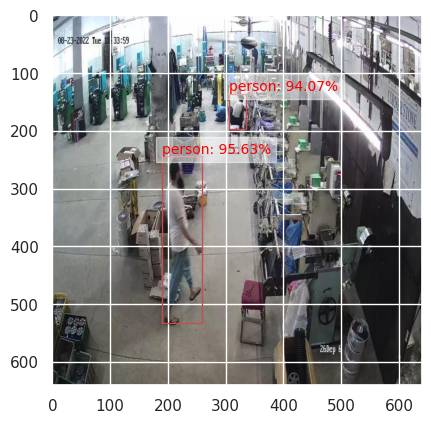

Visualizing prediction for image 2:


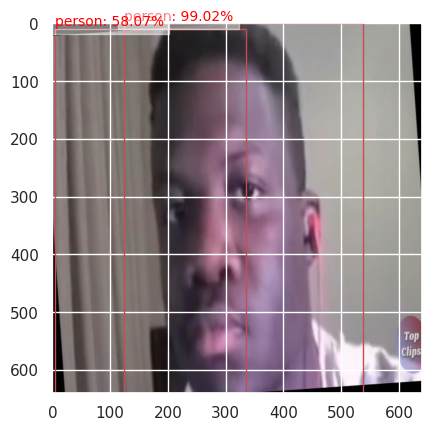

Visualizing prediction for image 3:


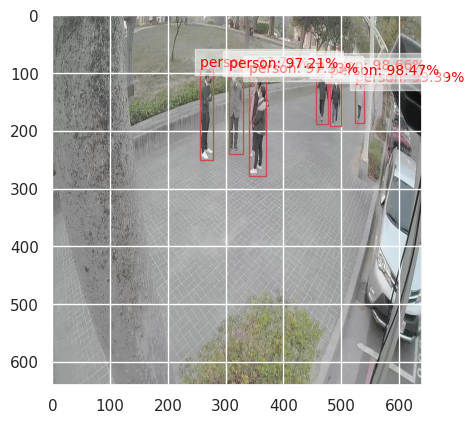

Visualizing prediction for image 4:


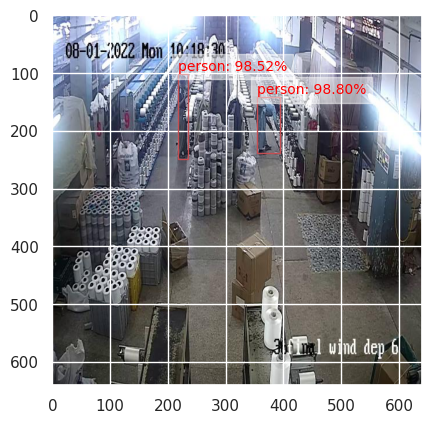

Visualizing prediction for image 5:


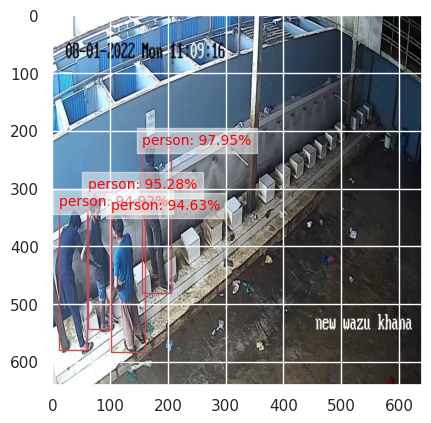

In [ ]:
# Melakukan Test pada dataset menggunakan model yang sudah ditraining
# Access the original dataset from the Subset object
# Check if dataset is a Subset and access the original dataset accordingly
if isinstance(dataset, torch.utils.data.Subset):
    original_dataset_for_names = dataset.dataset
else:
    original_dataset_for_names = dataset

# Get the label-to-name mapping from the original dataset's coco_data
# Ensure coco_data is accessible and has 'categories'
label_to_name = {cat['id']: cat['name'] for cat in original_dataset_for_names.coco_data.get('categories', []) if cat['id'] > 0}

# We'll use a placeholder for index 0 (background).
class_names_for_viz = ['background'] + [label_to_name.get(i, f'Unknown Class {i}') for i in sorted(label_to_name.keys())]


# Iterate through the original images and filtered predictions
for i in range(len(original_images)):
    image = original_images[i]
    prediction = filtered_predictions[i]

    # Convert PIL Image to NumPy array
    image_np = np.array(image)

    # Prepare the target dictionary in a format visualize_sample expects
    # It needs 'boxes' and 'labels' as tensors.
    target_for_viz = {
        'boxes': prediction['boxes'],
        'labels': prediction['labels'],
        'scores': prediction['scores'] # Include scores for visualization
    }

    # Visualize the sample
    print(f"Visualizing prediction for image {i+1}:")
    visualize_sample(image_np, target_for_viz, class_names_for_viz)

Saving WhatsApp Image 2025-11-03 at 3.32.17 PM.jpeg to WhatsApp Image 2025-11-03 at 3.32.17 PM (1).jpeg


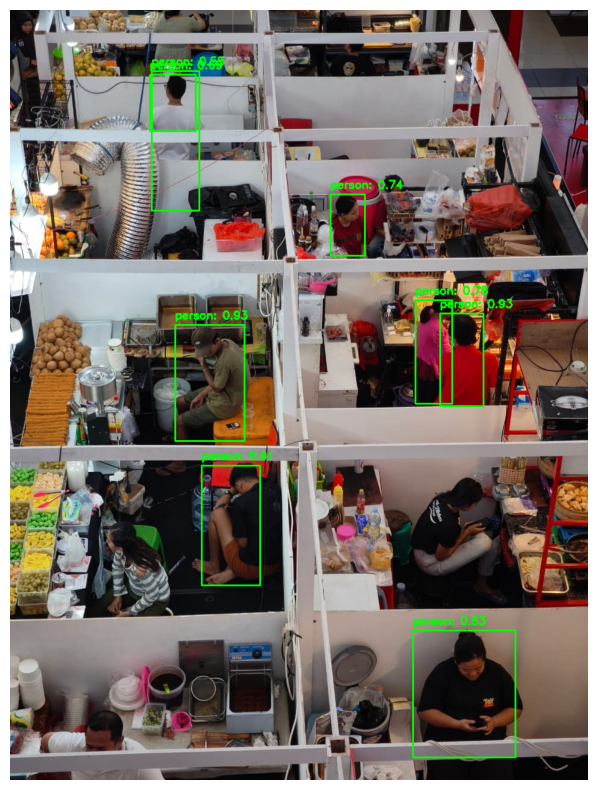

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np

# -------------------------------
# 1. Upload dan load gambar
# -------------------------------
from google.colab import files
uploaded = files.upload()  # pilih gambar dari lokal
img_path = list(uploaded.keys())[0]

# -------------------------------
# 2. Load gambar dan ubah ke tensor
# -------------------------------
image = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.ToTensor()  # konversi ke tensor
])
img_tensor = transform(image).to(device)  # device: cuda/cpu sesuai model

# -------------------------------
# 3. Prediksi menggunakan model
# -------------------------------
model.eval()
with torch.no_grad():
    prediction = model([img_tensor])  # output list, ambil [0] utk batch 1

# -------------------------------
# 4. Visualisasi bounding box + label + skor
# -------------------------------
# Ambil hasil prediksi
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()

# Atur threshold agar hanya kotak yang akurat ditampilkan
threshold = 0.5
boxes = boxes[scores >= threshold]
labels = labels[scores >= threshold]
scores = scores[scores >= threshold]

# Ambil class name dari dataset (jika punya mapping id → nama)
class_names = ["background", "person"]  # ubah sesuai dataset kamu

# Konversi gambar ke format untuk OpenCV
img_cv2 = np.array(image)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR)

# Gambar bounding box
for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img_cv2, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"{class_names[label]}: {score:.2f}"
    cv2.putText(img_cv2, text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Tampilkan hasil
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
